In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import matplotlib.pyplot as plt
#import scienceplots

#plt.style.use([ 'science']) # 'notebook' 'science'
PLOT_DIR = "../experiments/plots"

In [43]:
search_data = {
    "num_entities": [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000],
    "Exact":[2.798,6.482,13.683,20.145,25.788,38.183,52.098,64.081,97.705,129.498,169.355,202.125,239.98,281.573],
    "MultiVecHNSW": [0.572,0.625,0.759,0.750,0.774,0.815,0.824,0.962,1.015,1.143,1.148,1.158,1.147,1.187],
    "HNSWRerank": [1.561,2.186,2.664,3.267,3.513,4.516,4.994,5.294,5.960,7.061,7.508,8.540,9.272,8.939]
}

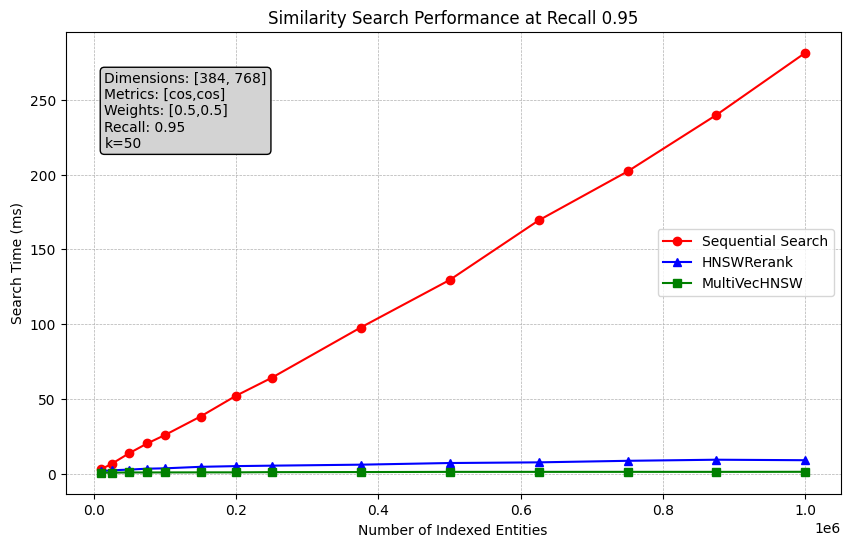

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(search_data["num_entities"], search_data["Exact"], marker='o', linestyle='-', label='Sequential Search', color='red')
plt.plot(search_data["num_entities"], search_data["HNSWRerank"], marker='^', linestyle='-', label='HNSWRerank', color='blue')
plt.plot(search_data["num_entities"], search_data["MultiVecHNSW"], marker='s', linestyle='-', label='MultiVecHNSW', color='green')

#plt.xscale('log')
#plt.yscale('log')

plt.xlabel('Number of Indexed Entities')
plt.ylabel('Search Time (ms)')
plt.title('Similarity Search Performance at Recall 0.95')
plt.legend()

# info box
info_text = ("Dimensions: [384, 768]\nMetrics: [cos,cos]\nWeights: [0.5,0.5]\nRecall: 0.95\nk=50")
plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# save plot
#plt.savefig(f"{PLOT_DIR}/similarity_search_performance.png", dpi=900, bbox_inches='tight')

plt.show()

In [45]:
construction_data =  {
    "num_entities": [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000],
    "MultiVecHNSW": [13.57,41.440,96.85,144.69,200.67,314.693376,430.1843251,550.52,870.79,1170.12,1447.72,1783.51,2128.36,2575.93],
    "HNSWRerank": [15.96,53.86,125.21,202.61,276.81,438.93,607.42,777.03,1222.65,1683.63,2166.75,2708.79,3164.55,3838.43]
}

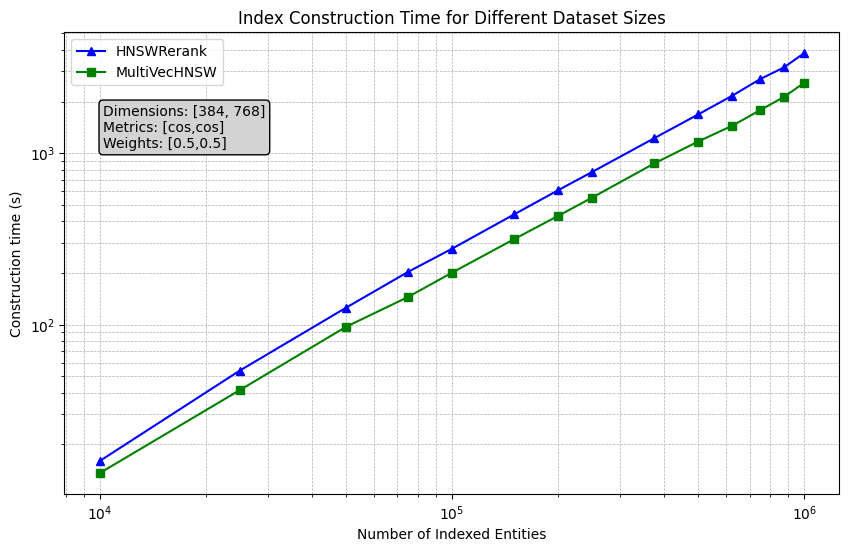

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(construction_data["num_entities"], construction_data["HNSWRerank"], marker='^', linestyle='-', label='HNSWRerank', color='blue')
plt.plot(construction_data["num_entities"], construction_data["MultiVecHNSW"], marker='s', linestyle='-', label='MultiVecHNSW', color='green')

plt.xscale('log')
plt.yscale('log')


plt.xlabel('Number of Indexed Entities')
plt.ylabel('Construction time (s)')
plt.title('Index Construction Time for Different Dataset Sizes')
plt.legend()

# info box
info_text = ("Dimensions: [384, 768]\nMetrics: [cos,cos]\nWeights: [0.5,0.5]")
plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))


plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# save plot
plt.savefig(f"{PLOT_DIR}/index_construction.svg", dpi=200, bbox_inches='tight')

plt.show()

In [47]:
from src.evaluation.evaluation_params import Params, MultiVecHNSWConstructionParams, MultiVecHNSWSearchParams 
from src.evaluation.evaluation import sanitise_path_string, compute_recall
import os
import numpy as np
from collections import defaultdict

In [48]:
BASE_DIR = "/Users/yavuz/scalable-multimodal-similarity-search/experiments/"
CONSTRUCTION_DIR = BASE_DIR + "construction/"
SEARCH_DIR = BASE_DIR + "search/"
EXACT_RESULTS_FOLDER = BASE_DIR + "exact_results/"
SAVED_INDEX_DIR = BASE_DIR + "saved_index/"

RERANK_CONSTRUCTION_DIR = BASE_DIR + "rerank_construction/"
RERANK_SEARCH_DIR = BASE_DIR + "rerank_search/"

SEARCH_WEIGHTS_DIR = BASE_DIR + "search_weights_exps/"

FIGURE_DPI = 200

In [49]:
from src.evaluation.plot_utils import *

In [50]:
p = Params(modalities=2, dimensions=[384, 768], metrics=["cos", "cos"], weights=[0.5, 0.5], index_size=10_000)
p.k=50
get_exact_results_folder(p)

'2_:384,768:_:cos,cos:_:0.5,0.5:_10000_50/'

In [51]:
def get_latest_experiment_file(folder, prev_experiment_index=1):
    """ Get the latest experiment file in the folder."""
    files = os.listdir(folder)
    # get the latest experiment file (file name is time)
    files.sort()
    data_file = files[-prev_experiment_index] 
    return data_file

def get_matching_experiment_folder(folder, query_ids):
    """Given a folder and query_ids, return the subfolder (for ef experiments) with the matching query_ids."""
    subfolders = os.listdir(folder)
    subfolders.sort(reverse=True) # start search from latest
    for subfolder in subfolders:
        if subfolder.startswith("."):
            continue
        
        # get files in the subfolder
        ef_folders = os.listdir(folder + "/" + subfolder)
        
        # get an ef folder in the subfolder
        for ef_folder in ef_folders:
            if ef_folder.startswith("."):
                continue
            # load query_ids.npy file
            query_ids_file = os.path.join(folder, subfolder, ef_folder, "query_ids.npy")
            loaded_query_ids = np.load(query_ids_file)

            # check if queries are the same
            if np.array_equal(query_ids, loaded_query_ids):
                return folder + "/" + subfolder
                    
    assert False, f"Could not find matching experiment folder for {folder}"

In [52]:
def read_exact_results_times_and_query_ids(params, num_entities, search_dir=EXACT_RESULTS_FOLDER, prev_experiment_index=1):
    exact_search_times = {}
    query_ids_dict = {}
    for num_entity in num_entities:
        params.index_size = num_entity
        search_folder = search_dir + get_exact_results_folder(params)
        
        # get the latest experiment file
        data_folder = get_latest_experiment_file(search_folder, prev_experiment_index)
        
        # read results.npz file
        data_file = os.path.join(search_folder, data_folder, "results.npz")
        query_ids_file = os.path.join(search_folder, data_folder, "query_ids.npy")
        
        #load the data
        query_ids = np.load(query_ids_file)
        times = np.load(os.path.join(search_folder, data_file))["search_times"]
        assert len(times) == len(query_ids) == 1000, f"Got {len(times)} times and {len(query_ids)} query ids at {query_ids_file}"
        print(f"Using queries from {query_ids_file} for {num_entity} entities")
        query_ids_dict[num_entity] = query_ids
        exact_search_times[num_entity] = times
        
    return exact_search_times, query_ids_dict

def read_exact_search_times_for_query_ids(p: Params, num_entities, query_ids_dict, search_dir=EXACT_RESULTS_FOLDER):
    """
    Return exact results for this set of inputs, and query ids.
    """
    
    exact_search_times = {}

    for num_entity in num_entities:
        save_folder = search_dir + sanitise_path_string(
            f"{p.modalities}_{p.dimensions}_{p.metrics}_{p.weights}_{num_entity}_{p.k}/", ":")
        
        assert os.path.exists(save_folder), f"Folder {save_folder} does not exist"
    
        query_ids = query_ids_dict[num_entity]
        # iterate over every folder in save_folder
        for folder in os.listdir(save_folder):
            # check folder is actually a folder
            if not os.path.isdir(save_folder + folder):
                continue
            query_path = save_folder + folder + "/query_ids.npy"
            if not os.path.exists(query_path):
                print(f"Warning: {query_path} not found, skipping")
            cached_query_ids = np.load(query_path)
            if np.array_equal(query_ids, cached_query_ids):
                #print(f"Loading cached results from {save_folder + folder}")
                data = np.load(save_folder + folder + "/results.npz")
                exact_search_times[num_entity] = data["search_times"]
                break
        
        assert num_entity in exact_search_times, f"Could not find results for {p.query_ids} in {save_folder}"
        
    return exact_search_times

In [53]:
def find_results_at_target_recall(ef_folders_root):
    if construction_params.target_degree == 32:
        target_recall = 0.95
    else:
        target_recall = 0.9
        
    ef_folders = os.listdir(ef_folders_root)
    # remove any folder that starts with "."
    ef_folders = [ef_folder for ef_folder in ef_folders if not ef_folder.startswith(".")]
    # sort the folders by ef value
    ef_folders.sort(key= lambda x: int(x.split("_")[1]))
    
    for ef_folder in ef_folders:
        # load results.npz file
        results = np.load(os.path.join(ef_folders_root, ef_folder, "results.npz"))
        # results contains search_times, recall_scores, ef_search, results
        assert ef_folder.split("_")[1] == str(results["ef_search"])
        # get recall scores
        recall_scores = results["recall_scores"]
        
        # check if we have the target recall
        if np.mean(recall_scores) >= target_recall:
            return results["ef_search"], results["search_times"]
        
    assert False, f"Could not find results at target recall {target_recall} in {ef_folders_root}"

In [54]:
def read_search_times(params, construction_params, num_entities, query_ids_dict, search_base_folder=SEARCH_DIR, prev_experiment_index=1):
    search_times = {}
    recall_achieving_ef = {}
    for num_entity in num_entities:
        params.index_size = num_entity
        query_ids = query_ids_dict[num_entity]
                
        search_folder = search_base_folder + get_construction_folder(params) + get_hnsw_construction_params_folder(construction_params)
        
        data_folder = get_matching_experiment_folder(search_folder, query_ids)
        
        recall_achieving_ef[num_entity], search_times[num_entity] = find_results_at_target_recall(data_folder)
    
    return search_times, recall_achieving_ef    

def get_query_id_from_search_folder(folder):
    """Get the query id from the search folder."""
    # get the latest experiment folder
    subfolders = os.listdir(folder)
    subfolders.sort(reverse=True) # start search from latest
    for subfolder in subfolders:
        if subfolder.startswith("."):
            continue
        # load query_ids.npy file
        query_ids_file = os.path.join(folder, subfolder, "query_ids.npy")
        loaded_query_ids = np.load(query_ids_file)
        return loaded_query_ids
    assert False, f"Could not find query ids in {folder}"

def get_search_times_and_query_ids(params, construction_params, num_entities, search_base_folder=SEARCH_DIR, prev_experiment_index=1):
    """For a given parameter setting, get the latest experiment folder and read the search times and query ids."""
    search_times = {}
    query_ids_dict = {}
    recall_achieving_ef = {}

    for num_entity in num_entities:
        params.index_size = num_entity
        search_folder = search_base_folder + get_construction_folder(params) + get_hnsw_construction_params_folder(construction_params)
                
        data_folder = os.path.join(search_folder, get_latest_experiment_folder(search_folder, prev_experiment_index=prev_experiment_index))
        
        query_ids = get_query_id_from_search_folder(data_folder)
        query_ids_dict[num_entity] = query_ids
        
        # load results.npz file        
        recall_achieving_ef[num_entity], search_times[num_entity] = find_results_at_target_recall(data_folder)
        
    return search_times, recall_achieving_ef, query_ids_dict


In [55]:
def convert_to_ms(search_times_dict):
    search_times_dict_new = {}
    for num_entity in search_times_dict:
        search_times_dict_new[num_entity] = [x * 1000 for x in search_times_dict[num_entity]]
    return search_times_dict_new

def plot_search_results_with_baselines(params, construction_params, num_entities, exact_search_times, search_times_multivechnsw, search_times_rerankhnsw, title="Similarity Search Performance at Recall 0.95", log_scale=True):
    confidence = 0.95
    linewidth = 1
    # convert to ms
    num = 100
    search_times_multivechnsw = convert_to_ms(search_times_multivechnsw)
    search_times_rerankhnsw = convert_to_ms(search_times_rerankhnsw)
    exact_search_times = convert_to_ms(exact_search_times)
    
    means_multivechnsw = []
    means_rerankhnsw = []
    means_exact = []
    cis_multivechnsw = []
    cis_rerankhnsw = []
    cis_exact = []
    for num_entity in num_entities:
        mean_multivechnsw, ci_multivechnsw = compute_mean_and_ci_stats(search_times_multivechnsw[num_entity][-num:], confidence)
        mean_rerankhnsw, ci_rerankhnsw = compute_mean_and_ci_stats(search_times_rerankhnsw[num_entity][-num:], confidence)
        mean_exact, ci_exact = compute_mean_and_ci_stats(exact_search_times[num_entity][-num:], confidence)
        
        means_multivechnsw.append(mean_multivechnsw)
        means_rerankhnsw.append(mean_rerankhnsw)
        means_exact.append(mean_exact)
        
        cis_multivechnsw.append(ci_multivechnsw)
        cis_rerankhnsw.append(ci_rerankhnsw)
        cis_exact.append(ci_exact)
        
    # convert to numpy
    means_multivechnsw = np.array(means_multivechnsw)
    means_rerankhnsw = np.array(means_rerankhnsw)
    means_exact = np.array(means_exact)
    cis_multivechnsw = np.array(cis_multivechnsw)
    cis_rerankhnsw = np.array(cis_rerankhnsw)
    cis_exact = np.array(cis_exact)
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(num_entities, means_exact, marker='o', linestyle='-', label='ExactMultiVecIndex', color='red', linewidth=linewidth)
    plt.fill_between(num_entities, 
                     means_exact - cis_exact, 
                     means_exact + cis_exact,
                     color='red', alpha=0.2)
    
    plt.plot(num_entities, means_rerankhnsw, marker='s', linestyle='-', label='HNSWRerank', color='blue', linewidth=linewidth)
    plt.fill_between(num_entities,
                        means_rerankhnsw - cis_rerankhnsw,
                        means_rerankhnsw + cis_rerankhnsw,
                        color='blue', alpha=0.2)
    
    plt.plot(num_entities, means_multivechnsw, marker='^', linestyle='-', label='MultiVecHNSW', color='green', linewidth=linewidth)
    plt.fill_between(num_entities,
                        means_multivechnsw - cis_multivechnsw,
                        means_multivechnsw + cis_multivechnsw,
                        color='green', alpha=0.2)
        
    
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
    else:
        plt.gca().xaxis.set_major_formatter(FuncFormatter(format_xaxis))

    plt.xlabel('Number of Indexed Entities')
    plt.ylabel('Search Time (ms)')
    plt.title(title)
    plt.legend()

    # info box
    info_text = f"Dimensions: {params.dimensions}\nMetrics: {params.metrics}\nWeights: {params.weights}\nTarget Degree: {construction_params.target_degree}\nMax Degree: {construction_params.max_degree}\nEf Construction: {construction_params.ef_construction}"
    plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # annotate improvement
    y_exact = means_exact[-1]
    y_hnsw = means_rerankhnsw[-1]
    y_multivec = means_multivechnsw[-1]
    
    improvement_over_exact = y_exact / y_multivec
    improvement_over_hnsw = y_hnsw / y_multivec
    
    # arrow from exact
    x_final = num_entities[-1] + 200_000
    plt.annotate(
        '',
        xy=(x_final, y_multivec),      
        xytext=(x_final, y_exact),   
        arrowprops=dict(
            arrowstyle='->', 
            color='red', 
            lw=1.5, 
            shrinkA=0, 
            shrinkB=0
        )
    )
    
    mid_y_exact_multivec = (y_exact + y_multivec) / 2
    plt.text(
        x_final * 0.7,              
        mid_y_exact_multivec,       
        f'{improvement_over_exact:.1f}x',
        color='red',
        ha='left',                   
        va='center',                 
        fontsize=10
    )
    
    # arrow from rerank
    x_final = num_entities[-1] + 100_000
    plt.annotate(
        '',
        xy=(x_final, y_multivec),    
        xytext=(x_final, y_hnsw),     
        arrowprops=dict(
            arrowstyle='->', 
            color='blue', 
            lw=1.5, 
            shrinkA=0, 
            shrinkB=0
            )
    )
    
    mid_y_hnsw_multivec = (y_hnsw + y_multivec) / 2
    plt.text(
        x_final * 0.8, 
        mid_y_hnsw_multivec,          
        f'{improvement_over_hnsw:.1f}x',
        color='blue',
        ha='left',                  
        va='center',                   
        fontsize=10
    )
    
    # save plot
    plt.savefig(f"{PLOT_DIR}/similarity_search_performance_with_baselines_efC{construction_params.ef_construction}.png", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()
    

In [56]:
params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=None, k=50)
construction_params = MultiVecHNSWConstructionParams(target_degree=32, max_degree=32, ef_construction=200, seed=1)
num_entities = [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000]


times_multivechnsw_over_multiple_seeds = defaultdict(list)
times_exact_over_multiple_seeds = defaultdict(list)
times_rerank_over_multiple_seeds = defaultdict(list)

for seed in [1,2,3]:
    construction_params.seed = seed

    search_times_multivechnsw, _, query_ids_dict = get_search_times_and_query_ids(params, construction_params, num_entities, search_base_folder=SEARCH_DIR)
    
    exact_search_times = read_exact_search_times_for_query_ids(params, num_entities, query_ids_dict, search_dir=EXACT_RESULTS_FOLDER)
    
    search_times_rerankhnsw, recall_achieving_ef_rerankhnsw  = read_search_times(params, construction_params, num_entities, query_ids_dict, search_base_folder=RERANK_SEARCH_DIR)
    
    for num_entity in num_entities:
        times_multivechnsw_over_multiple_seeds[num_entity].extend(search_times_multivechnsw[num_entity])
        times_exact_over_multiple_seeds[num_entity].extend(exact_search_times[num_entity])
        times_rerank_over_multiple_seeds[num_entity].extend(search_times_rerankhnsw[num_entity])

In [57]:
print(len(times_multivechnsw_over_multiple_seeds[1_000_000])), print(len(times_exact_over_multiple_seeds[1_000_000])), print(len(times_rerank_over_multiple_seeds[1_000_000]))

3000
3000
3000


(None, None, None)

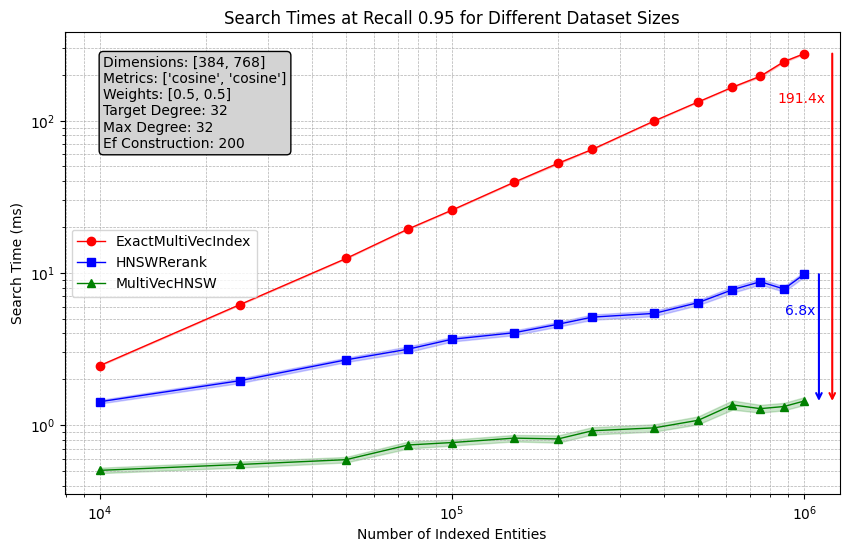

In [58]:
plot_search_results_with_baselines(params, construction_params, num_entities, times_exact_over_multiple_seeds, times_multivechnsw_over_multiple_seeds, times_rerank_over_multiple_seeds, title="Search Times at Recall 0.95 for Different Dataset Sizes")

In [59]:
params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=None, k=50)
construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=1)
num_entities = [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000]
#num_entities = [ 500_000, 625_000, 750_000, 875_000, 1_000_000]


times_multivechnsw_over_multiple_seeds = defaultdict(list)
times_exact_over_multiple_seeds = defaultdict(list)
times_rerank_over_multiple_seeds = defaultdict(list)

for seed in [2]:
    construction_params.seed = seed

    search_times_multivechnsw, _, query_ids_dict = get_search_times_and_query_ids(params, construction_params, num_entities, search_base_folder=SEARCH_DIR)
    
    exact_search_times = read_exact_search_times_for_query_ids(params, num_entities, query_ids_dict, search_dir=EXACT_RESULTS_FOLDER)
    
    search_times_rerankhnsw, recall_achieving_ef_rerankhnsw  = read_search_times(params, construction_params, num_entities, query_ids_dict, search_base_folder=RERANK_SEARCH_DIR)
    
    for num_entity in num_entities:
        times_multivechnsw_over_multiple_seeds[num_entity].extend(search_times_multivechnsw[num_entity])
        times_exact_over_multiple_seeds[num_entity].extend(exact_search_times[num_entity])
        times_rerank_over_multiple_seeds[num_entity].extend(search_times_rerankhnsw[num_entity])

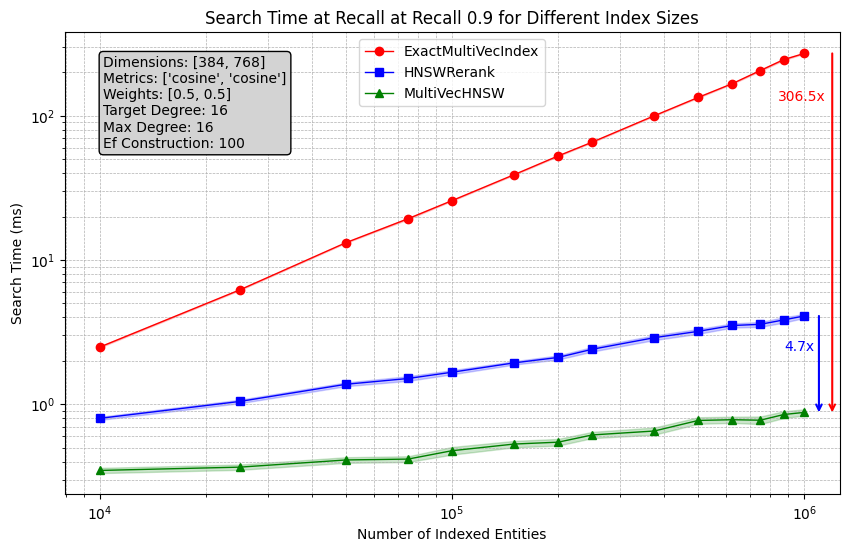

In [60]:
plot_search_results_with_baselines(params, construction_params, num_entities, exact_search_times, search_times_multivechnsw, search_times_rerankhnsw, title="Search Time at Recall at Recall 0.9 for Different Index Sizes", log_scale=True)

In [61]:
def read_construction_times(params, specific_construction_params, num_entities, construction_dir=CONSTRUCTION_DIR, rerank_construction_dir=RERANK_CONSTRUCTION_DIR):
    
    hnsw_construction_times = defaultdict(list)
    rerank_construction_times = defaultdict(list)
   
    for num_entity in num_entities:
        params.index_size = num_entity

        # MultiVecHNSW
        construction_folder = construction_dir + get_construction_folder(params) + get_hnsw_construction_params_folder(specific_construction_params)
        
        data_file = get_latest_experiment_file(construction_folder)
       
        # load the .npz file
        data = np.load(os.path.join(construction_folder, data_file))["time"]
        
        # get the time
        hnsw_construction_times[num_entity].append(data[0])
        
        # HNSWRerank
        rerank_construction_folder = rerank_construction_dir + get_construction_folder(params) + get_hnsw_construction_params_folder(specific_construction_params)
        
        rerank_data_file = get_latest_experiment_file(rerank_construction_folder)
        
        rerank_indexes_times = np.load(os.path.join(rerank_construction_folder, rerank_data_file))["time"]
        rerank_construction_times[num_entity].append(sum(rerank_indexes_times))
        
    return hnsw_construction_times, rerank_construction_times

def plot_construction_times(params, specific_construction_params, num_entities, hnsw_construction_times, rerank_construction_times, log_scale=True):
    
    confidence = 0.95
    hnsw_means = []
    rerank_means = []
    hnsw_cis = []
    rerank_cis = []
    for num_entity in num_entities:
        mean_hnsw, ci_hnsw = compute_mean_and_ci_stats(hnsw_construction_times[num_entity], confidence)
        mean_rerank, ci_rerank = compute_mean_and_ci_stats(rerank_construction_times[num_entity], confidence)
        
        hnsw_means.append(mean_hnsw)
        rerank_means.append(mean_rerank)
        
        hnsw_cis.append(ci_hnsw)
        rerank_cis.append(ci_rerank)
        
    # convert to numpy
    hnsw_means = np.array(hnsw_means)
    rerank_means = np.array(rerank_means)
    hnsw_cis = np.array(hnsw_cis)
    rerank_cis = np.array(rerank_cis)   
    
    plt.figure(figsize=(10, 6))
    plt.plot(num_entities, rerank_means, marker='^', linestyle='-', label='HNSWRerank', color='blue')
    plt.fill_between(num_entities,
                        rerank_means - rerank_cis,
                        rerank_means + rerank_cis,
                        color='blue', alpha=0.2)
    
    plt.plot(num_entities, hnsw_means, marker='s', linestyle='-', label='MultiVecHNSW', color='green')
    plt.fill_between(num_entities,
                        hnsw_means - hnsw_cis,
                        hnsw_means + hnsw_cis,
                        color='green', alpha=0.2)
    
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')

    plt.xlabel('Number of Indexed Entities')
    plt.ylabel('Construction time (s)')
    plt.title('Index Construction Time for Different Dataset Sizes')
    plt.legend()

    # info box
    info_text = f"Dimensions: {params.dimensions}\nMetrics: {params.metrics}\nWeights: {params.weights}\nTarget Degree: {specific_construction_params.target_degree}\nMax Degree: {specific_construction_params.max_degree}\nEf Construction: {specific_construction_params.ef_construction}"
    plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    
    # annotate improvement
    y_multivec = hnsw_means[-1]
    y_rerank = rerank_means[-1]
    improvement_over_rerank = y_rerank / y_multivec
    
    # arrow from rerank
    if log_scale:
        x_final = num_entities[-1] + 200_000
        text_shift_ratio = 0.8
    else:
        x_final = num_entities[-1] + 20_000
        text_shift_ratio = 0.95

    plt.annotate(
        '',
        xy=(x_final, y_multivec),      
        xytext=(x_final, y_rerank),   
        arrowprops=dict(
            arrowstyle='->', 
            color='blue', 
            lw=1.5, 
            shrinkA=0, 
            shrinkB=0
        )
    )
    
    mid_y_rerank_multivec = (y_rerank + y_multivec) / 2
    plt.text(
        x_final * text_shift_ratio,              
        mid_y_rerank_multivec,       
        f'{improvement_over_rerank:.1f}x',
        color='blue',
        ha='left',                   
        va='center',                 
        fontsize=10
    )
    
    if not log_scale:
        plt.gca().xaxis.set_major_formatter(FuncFormatter(format_xaxis))
    
    # save plot
    log = "_log" if log_scale else ""
    plt.savefig(f"{PLOT_DIR}/index_construction_{specific_construction_params.target_degree}_{specific_construction_params.max_degree}_{specific_construction_params.ef_construction}{log}.png", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

In [62]:
params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=None)
num_entities = [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000]

In [63]:
construction_params = MultiVecHNSWConstructionParams(target_degree=32, max_degree=32, ef_construction=200, seed=3)

hnsw_construction_times = defaultdict(list)
rerank_construction_times = defaultdict(list) 

for seed in [1,2,3]:
    construction_params.seed = seed
    hnsw_seed_times, rerank_seed_times = read_construction_times(params, construction_params, num_entities)
    for num_entity in num_entities:
        hnsw_construction_times[num_entity].extend(hnsw_seed_times[num_entity])
        rerank_construction_times[num_entity].extend(rerank_seed_times[num_entity])


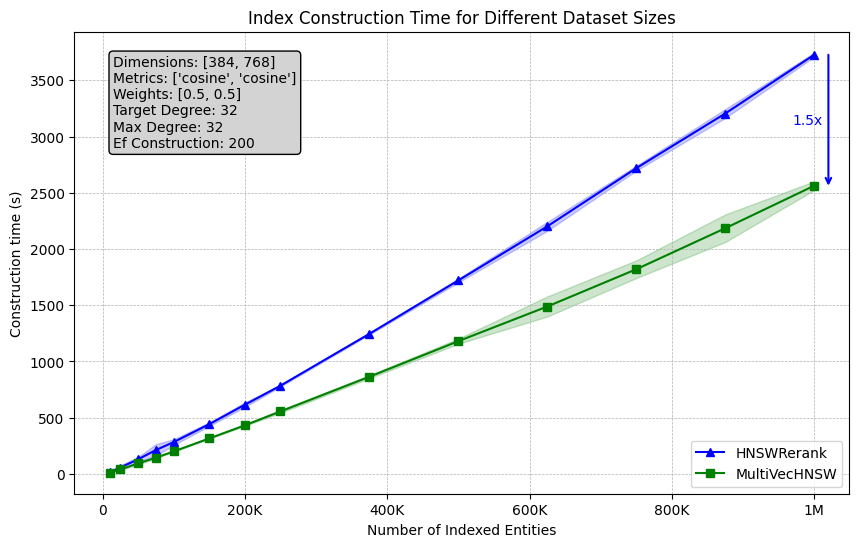

In [64]:
plot_construction_times(params, construction_params, num_entities, hnsw_construction_times, rerank_construction_times, log_scale=False)

In [65]:
num_entities2 = [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000]

construction_params2 = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

hnsw_construction_times2 = defaultdict(list)
rerank_construction_times2 = defaultdict(list) 
for seed in [1,2,3]:
    construction_params2.seed = seed
    hnsw_seed_times, rerank_seed_times = read_construction_times(params, construction_params2, num_entities2)
    for num_entity in num_entities:
        hnsw_construction_times2[num_entity].extend(hnsw_seed_times[num_entity])
        rerank_construction_times2[num_entity].extend(rerank_seed_times[num_entity])

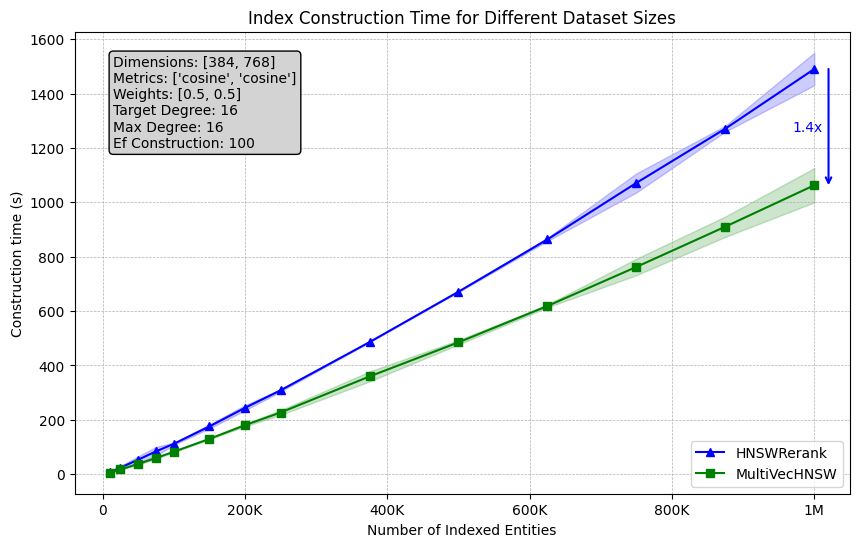

In [66]:
plot_construction_times(params, construction_params2, num_entities2, hnsw_construction_times2, rerank_construction_times2, log_scale=False)

In [67]:
def plot_hnsw_construct_with_different_params(num_entities, params, construction_params1, construction_params2, timesdict1, timesdict2, log_scale=False):
    
    confidence = 0.95
    means = []
    cis = []
    for times in [timesdict1, timesdict2]:
        means_times = []
        cis_times = []
        for num_entity in num_entities:
            mean, ci = compute_mean_and_ci_stats(times[num_entity], confidence)
            means_times.append(mean)
            cis_times.append(ci)

        means.append(np.array(means_times))
        cis.append(np.array(cis_times))
    
    means = np.array(means)
    cis = np.array(cis)
    
    plt.figure(figsize=(10, 6))
    plt.plot(num_entities, means[0], marker='^',linestyle='-', label=f'MultiVecHNSW targetDegree=maxDegree={construction_params1.target_degree}, efConstruction={construction_params1.ef_construction}', color='blue')
    plt.fill_between(num_entities,
                        means[0] - cis[0], 
                        means[0] + cis[0],
                        color='blue', alpha=0.2)
    
    plt.plot(num_entities, means[1], marker='^', linestyle='-', label=f'MultiVecHNSW targetDegree=maxDegree={construction_params2.target_degree}, efConstruction={construction_params2.ef_construction}', color='orange')
    plt.fill_between(num_entities,
                        means[1] - cis[1], 
                        means[1] + cis[1],
                        color='orange', alpha=0.2)
    
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
    else:
        plt.gca().xaxis.set_major_formatter(FuncFormatter(format_xaxis))

    plt.xlabel('Number of Indexed Entities')
    plt.ylabel('Construction time (s)')
    plt.title('Index Construction Time for Different Construction Settings')
    plt.legend()

    # info box
    info_text = f"Dimensions: {params.dimensions}\nMetrics: {params.metrics}\nWeights: {params.weights}"
    plt.annotate(info_text, xy=(0.05, 0.75), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # save plot
    log = "_log" if log_scale else ""
    plt.savefig(f"{PLOT_DIR}/index_construction_hnsw_comparison{log}.png", dpi=FIGURE_DPI, bbox_inches='tight')
        
    plt.show()

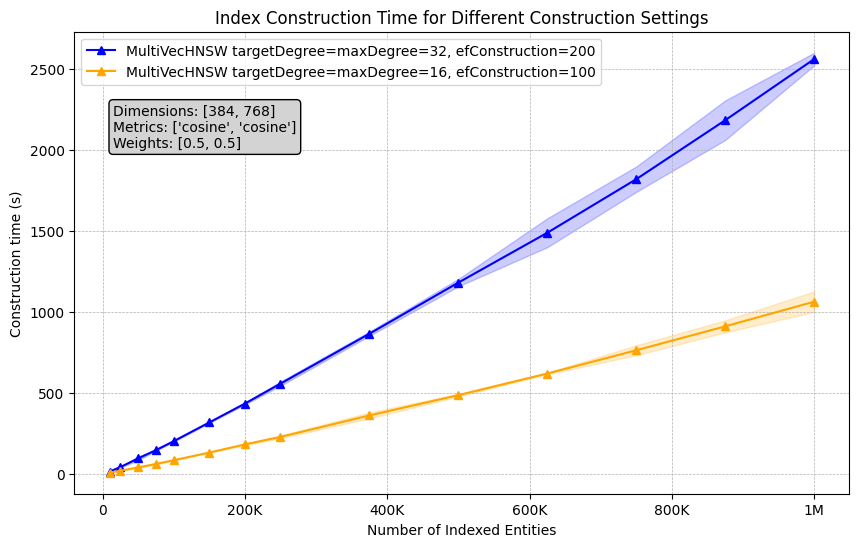

In [68]:
plot_hnsw_construct_with_different_params(num_entities, params, construction_params, construction_params2, hnsw_construction_times, hnsw_construction_times2)

In [69]:
def get_index_sizes(params, specific_construction_params, num_entities, saved_index_dir=SAVED_INDEX_DIR):
    
    index_sizes = defaultdict(list)
    for num_entity in num_entities:
        params.index_size = num_entity

        index_folder = saved_index_dir + get_construction_folder(params) + get_hnsw_construction_params_folder(specific_construction_params)
        
        data_file = get_latest_experiment_file(index_folder)
                
        index_file = os.path.join(index_folder, data_file)
        index_size = os.path.getsize(index_file)
        index_sizes[num_entity].append(index_size)
        
    return index_sizes

In [70]:
def get_gb_size_given_num_vectors(params, num_entity):
    total_dimensions = sum(params.dimensions)
    single_entity_size = total_dimensions * 4 # 4 bytes per vector
    return single_entity_size * num_entity / 10**9

In [71]:
def convert_to_GB(sizes_dict):
    sizes_dict_new = {}
    for num_entity in sizes_dict:
        sizes_dict_new[num_entity] = [x / 10**9 for x in sizes_dict[num_entity]]
    return sizes_dict_new

In [72]:

def plot_memory_sizes(params, construction_params1, construction_params2, num_entities, sizes1, sizes2, log_scale=True): 
    sizes1 = convert_to_GB(sizes1)
    sizes2 = convert_to_GB(sizes2)
    confidence = 0.95
    linewidth = 0.8
    means = []
    cis = []
    for sizes in [sizes1, sizes2]:
        means_sizes = []
        cis_sizes = []
        for num_entity in num_entities:
            mean, ci = compute_mean_and_ci_stats(sizes[num_entity], confidence)
            means_sizes.append(mean)
            cis_sizes.append(ci)

        means.append(np.array(means_sizes))
        cis.append(np.array(cis_sizes))
    
    means = np.array(means)
    cis = np.array(cis)
    
    plt.figure(figsize=(10, 6))
    plt.plot(num_entities, means[0], marker='^',linestyle='-', label=f'MultiVecHNSW targetDegree=maxDegree={construction_params1.target_degree}, efConstruction={construction_params1.ef_construction}', color='blue', linewidth=linewidth)
    plt.fill_between(num_entities,
                        means[0] - cis[0], 
                        means[0] + cis[0],
                        color='blue', alpha=0.2)
    
    plt.plot(num_entities, means[1], marker='^', linestyle='-', label=f'MultiVecHNSW targetDegree=maxDegree={construction_params2.target_degree}, efConstruction={construction_params2.ef_construction}', color='orange', linewidth=linewidth)
    plt.fill_between(num_entities,
                        means[1] - cis[1], 
                        means[1] + cis[1],
                        color='orange', alpha=0.2)
    
    plt.plot(num_entities, [get_gb_size_given_num_vectors(params, x) for x in num_entities], linestyle='--', color='red', label='Size of vectors', linewidth=linewidth)
    
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')

    plt.xlabel('Number of Indexed Entities')
    plt.ylabel('Memory Usage (GB)')
    plt.title('Index Memory Usage for Different Construction Settings')
    plt.legend()

    # info box
    info_text = f"Dimensions: {params.dimensions}\nMetrics: {params.metrics}\nWeights: {params.weights}"
    plt.annotate(info_text, xy=(0.05, 0.7), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # change ticklabel format to plain
    if not log_scale:
        ax = plt.gca()
        ax.ticklabel_format(style='plain', axis='x')
        ax.xaxis.set_major_formatter(FuncFormatter(format_xaxis))  # Apply custom formatter
            
    # save plot
    log = "_log" if log_scale else ""
    plt.savefig(f"{PLOT_DIR}/index_construction_memory_comparison{log}.png", dpi=FIGURE_DPI, bbox_inches='tight')
    
    plt.show()

In [73]:
params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=None)
num_entities = [500_000, 625_000, 750_000, 875_000, 1_000_000]
num_entities_all = [10_000, 25_000, 50_000, 75_000, 100_000, 150_000, 200_000, 250_000, 375_000, 500_000, 625_000, 750_000, 875_000, 1_000_000]

In [ ]:
construction_params1 = MultiVecHNSWConstructionParams(target_degree=32, max_degree=32, ef_construction=200, seed=3)
construction_params2 = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

sizes1 = defaultdict(list)
sizes2 = defaultdict(list)
for seed in [3]:
    construction_params1.seed = seed
    construction_params2.seed = seed
    seed_sizes1 = get_index_sizes(params, construction_params1, num_entities)
    seed_sizes2 = get_index_sizes(params, construction_params2, num_entities)
    for num_entity in num_entities:
        sizes1[num_entity].extend(seed_sizes1[num_entity])
        sizes2[num_entity].extend(seed_sizes2[num_entity])

In [76]:
large_index_sizes = defaultdict(list,
            {10000: [47410059, 47411975],
             25000: [118572259, 118569643],
             50000: [237099771, 237096183],
             75000: [355627627, 355623031],
             100000: [474104735, 474095971],
             150000: [711000435, 710994099],
             200000: [947839271, 947838671],
             250000: [1184605807, 1184604031],
             375000: [1776465063, 1776469051],
             500000: [2368172583, 2368170255],
             625000: [2959770687, 2959780631],
             750000: [3551331391, 3551348251],
             875000: [4142858267, 4142869007],
             1000000: [4734340979, 4734350395]})

small_index_sizes = defaultdict(list,
            {10000: [47018443, 47020519],
             25000: [117517971, 117521767],
             50000: [234993991, 234995487],
             75000: [352445687, 352447639],
             100000: [469868711, 469870095], #469MB
             150000: [704665311, 704673519],
             200000: [939427207, 939421815],
             250000: [1174154611, 1174146787],
             375000: [1760894583, 1760899651],
             500000: [2347562155, 2347563271],
             625000: [2934144891, 2934154099],
             750000: [3520684803, 3520682323],
             875000: [4107154203, 4107147755],
             1000000: [4693601415, 4693603507]}) #4.69 GB

In [78]:
sizes1 = large_index_sizes
sizes2 = small_index_sizes

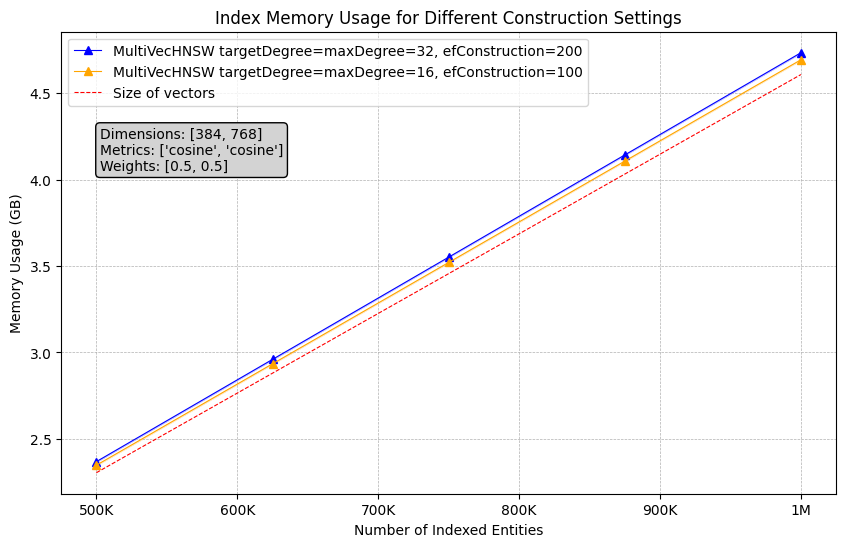

In [79]:
plot_memory_sizes(params, construction_params1, construction_params2, num_entities, sizes1, sizes2, log_scale=False)

In [519]:
def get_ef_exp_data(params, construction_params, search_base_folder=SEARCH_DIR):
    search_folder = search_base_folder + get_construction_folder(params) + get_hnsw_construction_params_folder(construction_params)
    
    selected_folder = get_latest_experiment_file(search_folder)
    ef_folders = os.listdir(search_folder +"/"+ selected_folder)
    ef_folders.sort()
    
    recall_scores_per_ef = {}
    search_times_per_ef = {}
    for ef_folder in ef_folders:
        if ef_folder.startswith("."):
            continue
        stats = ef_folder.split("_")
        k = int(stats[0])
        ef = int(stats[1])
        
        if ef >=k:
            # load results.npz file
            results = np.load(os.path.join(search_folder, selected_folder, ef_folder, "results.npz"))
            # results contains search_times, recall_scores, ef_search, results
            assert ef == results["ef_search"]
            assert ef not in recall_scores_per_ef
            recall_scores_per_ef[ef] = results["recall_scores"]
            search_times_per_ef[ef] = results["search_times"]
    
    return recall_scores_per_ef, search_times_per_ef


def plot_ef_exp_data(params, construction_params, recall_scores_per_ef, search_times_per_ef, title="Impact of efSearch on Recall and Search Time"):
    ef_values = sorted(recall_scores_per_ef.keys()) # skip first
    num_results = None
    for k,v in search_times_per_ef.items():
        search_times_per_ef[k] = [x * 1000 for x in v] # convert to ms
        num_results = len(search_times_per_ef[k])
        
    print(f"Averaged {num_results} query results")

    mean_recalls = []
    mean_times = []
    ci_recalls = []
    ci_times = []
    for ef in ef_values:
        mean_recall, ci_recall = compute_mean_and_ci_stats(recall_scores_per_ef[ef])
        mean_search_time, ci_search_time = compute_mean_and_ci_stats(search_times_per_ef[ef])
        
        mean_recalls.append(mean_recall)
        mean_times.append(mean_search_time)
        ci_recalls.append(ci_recall)
        ci_times.append(ci_search_time)
    
    mean_recalls = np.array(mean_recalls)
    mean_times = np.array(mean_times)
    ci_recalls = np.array(ci_recalls)
    ci_times = np.array(ci_times)
        
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # plot recall on the left axis
    ax1.plot(ef_values, mean_recalls, '-o', color='blue', label='Recall')
    ax1.fill_between(ef_values, 
                     mean_recalls - ci_recalls, 
                     mean_recalls + ci_recalls,
                     color='blue', alpha=0.2)
    ax1.set_xlabel('efSearch', fontsize=12)
    ax1.set_ylabel('Recall', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')
    # set upper limit to 1
    ax1.set_ylim(0.8, 1)
    
    # set x limit to be that of the ef values
    #ax1.set_xlim(min(ef_values)-10, max(ef_values)+10)
    
    # plot search time on the right axis
    ax2 = ax1.twinx()
    ax2.plot(ef_values, mean_times, '-s', color='red', label='Search Time')
    ax2.fill_between(ef_values, 
                     mean_times - ci_times, 
                     mean_times + ci_times,
                     color='red', alpha=0.2)
    ax2.set_ylabel('Search Time (ms)', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0.55, 3.15)

    # set xticks
    ax1.set_xticks(ef_values)
    
    # info box
    info_text = f"Dimensions: {params.dimensions}\nMetrics: {params.metrics}\nWeights: {params.weights}\nTarget Degree: {construction_params.target_degree}\nMax Degree: {construction_params.max_degree}\nEf Construction: {construction_params.ef_construction}\nk: 50"
    plt.annotate(info_text, xy=(0.7, 0.05), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgray'))

    # combine legends
    lines, labels = [], []
    for ax in [ax1, ax2]:
        ax_lines, ax_labels = ax.get_legend_handles_labels()
        lines.extend(ax_lines)
        labels.extend(ax_labels)
    ax1.legend(lines, labels, loc='upper left')
    
    ax1.grid(True, axis="y",linestyle="--", linewidth=0.5)
    plt.title(title, fontsize=12)
    
    # save plot
    plt.savefig(f"{PLOT_DIR}/ef_against_recall_and_search_{params.index_size}_ef{construction_params.ef_construction}", dpi=FIGURE_DPI, bbox_inches='tight')
    
    plt.show()
        

Averaged 1000 query results


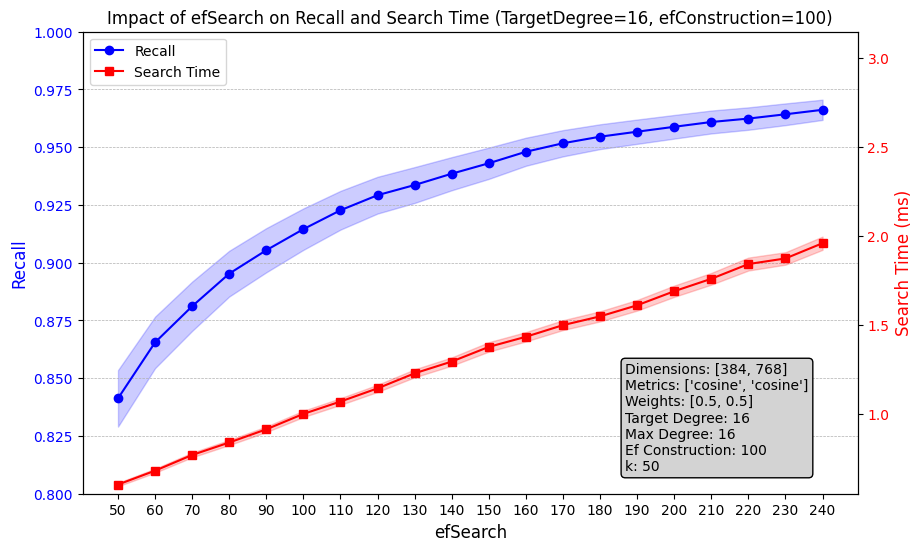

In [520]:
ef_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=1_000_000)
ef_exp_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)
recall_scores_per_ef, search_times_per_ef = get_ef_exp_data(ef_exp_params, ef_exp_construction_params)
plot_ef_exp_data(ef_exp_params, ef_exp_construction_params, recall_scores_per_ef, search_times_per_ef, title="Impact of efSearch on Recall and Search Time (TargetDegree=16, efConstruction=100)")

Averaged 1000 query results


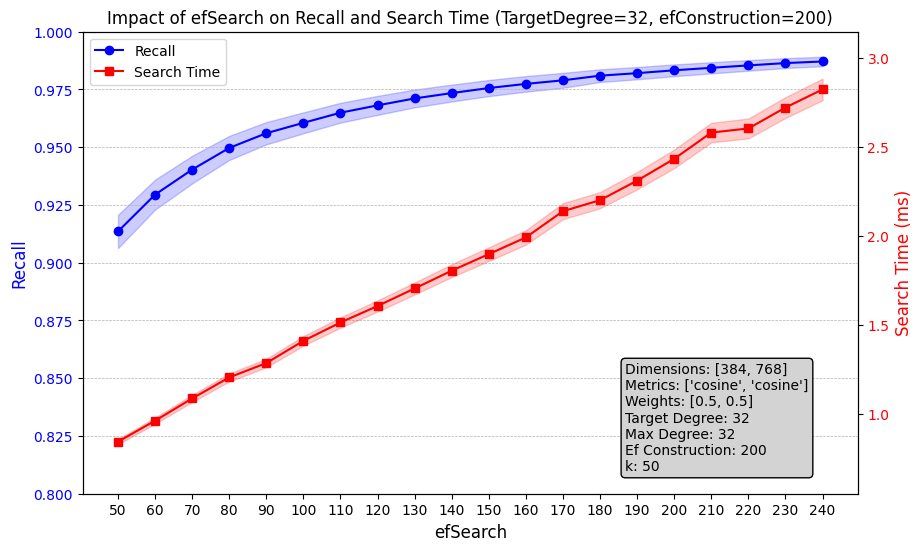

In [521]:
ef_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=1_000_000)
ef_exp_construction_params = MultiVecHNSWConstructionParams(target_degree=32, max_degree=32, ef_construction=200, seed=3)
recall_scores_per_ef, search_times_per_ef = get_ef_exp_data(ef_exp_params, ef_exp_construction_params)
plot_ef_exp_data(ef_exp_params, ef_exp_construction_params, recall_scores_per_ef, search_times_per_ef, title="Impact of efSearch on Recall and Search Time (TargetDegree=32, efConstruction=200)")